# Forecast POC Guide

This notebook will walk you through the process of building a custom collection of models with Amazon Forecast based on the time series data you have for your problem.

## Overview

1. Introduction to Amazon Forecast
1. Obtaining Your Data
1. Fitting the Data to Forecast
1. Determining Your Forecast Horizon (1st pass)
1. Building Your First Few Predictors
1. Visualizing Predictors
1. Making Decisions
1. Adding Related Time Series Data
1. Evaluations Again
1. Next Steps


## Introduction to Amazon Forecast

If you are not familiar with Amazon Forecast you can learn more about this tool on these pages:

* Product Page: https://aws.amazon.com/forecast/
* GitHub Sample Notebooks: https://github.com/aws-samples/amazon-forecast-samples
* Product Docs: https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. Wikipedia: https://en.wikipedia.org/wiki/Time_series
1. Toward's Data Science Primer: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
1. O'Reilly Book: https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1

As an exmaple for this POC guide we are going to select a dataset from the UCI repository of machine learning datasets. This is a great tool for finding datasets for various problems. In this particular case it is traffic data for a given section of interstate highway. More information on the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

To begin the cell below when executed will create a data folder and download our dataset into it, lastly it will extract the data into a csv file we can edit locally.







In [1]:
!mkdir data
!cd data && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!gunzip data/Metro_Interstate_Traffic_Volume.csv.gz

--2019-12-26 21:56:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K  1.37MB/s    in 0.3s    

2019-12-26 21:56:36 (1.37 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [2]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#import seaborn as sns
# Use seaborn style defaults and set the default figure size
#sns.set(rc={'figure.figsize':(11, 4)})

In [3]:
original_data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
original_data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


At this point we can see a few things about the data:

* Holidays seem to be specified
* There is a value for temp but the units are unclear
* Look like a few weather measurements as well
* The time series itself is hourly
* There is a final column called traffic_volume that hopefully is impacted by these other fields.

Reducing the dataset to the things that are absolutely critical for Amazon Forecast would yield something like the following:

1. item_id = This would just be set to 0 or 1, or some arbitary ID. Amazon Forecast is designed to work with multiple time series, so we are just going to define a singular one here.
1. timestamp = The one provided should suffice. 
1. traffic_volume = The value here should suffice as well for us, and will be what we look to predict going forward.

The other attributes provided can serve as a basis for related time series components when we get to that much later.

To assist with the initial exploration of the data. First you will use the code below to reduce the dataframe to only the columns needed, then add the item_id column. Lastly we will plot the values over time to see what our series looks like.


In [4]:
target_df = original_data.copy()
target_df = target_df[['date_time', 'traffic_volume']]
target_df.columns = ['TIMESTAMP', 'TARGET_VALUE']
target_df.head(5)

,TIMESTAMP,TARGET_VALUE
0,2012-10-02 09:00:00,5545
1,2012-10-02 10:00:00,4516
2,2012-10-02 11:00:00,4767
3,2012-10-02 12:00:00,5026
4,2012-10-02 13:00:00,4918


Start Date:  2012-10-02 09:00:00
End Date:  2018-09-30 23:00:00


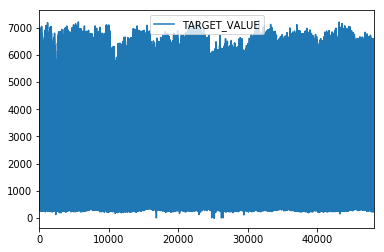

In [5]:
target_df.plot()
print("Start Date: ", min(target_df['TIMESTAMP']))
print("End Date: ", max(target_df['TIMESTAMP']))

By default the plot we are seeing is not the most helpful, at present it is very hard to see what variations within the data exists, and when those may be altered by time. Given we have hourly data a quick check could be to pick a date range and inspect it to see how the value shifts over time.

#TODO:

* Set column for timestamp to timestampe type or datetime type at least.
* Print Date Range of Dataset
* Select a particluar day
* Render
* Do the same for a week, month, and year?



In [6]:
target_df.info()
target_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 2 columns):
TIMESTAMP       48204 non-null object
TARGET_VALUE    48204 non-null int64
dtypes: int64(1), object(1)
memory usage: 753.3+ KB


,TARGET_VALUE
count,48204.000000
mean,3259.818355
std,1986.860670
min,0.000000
25%,1193.000000
50%,3380.000000
75%,4933.000000
max,7280.000000


In [6]:
target_df.set_index('TIMESTAMP', inplace=True)
print (target_df.index.min())
print (target_df.index.max())

2012-10-02 09:00:00
2018-09-30 23:00:00


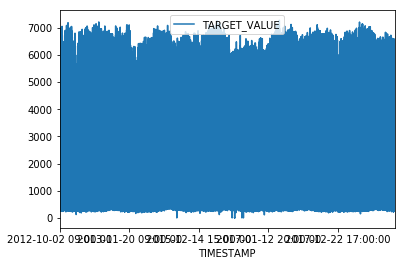

In [7]:
target_df.plot()

Given the data above, we can see that there exists historical data from October 2nd 2012 at 9 am until September 30th 2018. That is nearly 6 years of data. To make things a bit cleaner to evaluate in this case we will learn from 2013 until 2016 and then predict over 2017. From there we will explore the impact of just the target data, as well as the impact of related data like weather and temperature that were called out earlier. 

In [8]:
# Now we see 2012- 2017, lets just look at 2013
df_2013 = target_df.loc['2013-01-01': '2014-01-01']

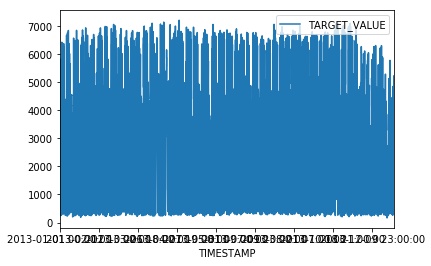

In [9]:
df_2013.plot()

In [10]:
df_2013_01_01 = target_df.loc['2013-01-01':'2013-01-02']

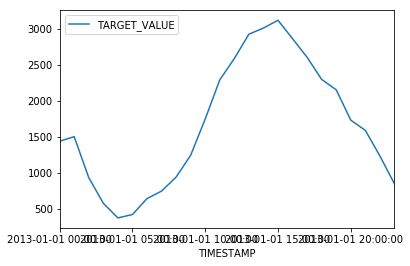

In [11]:
df_2013_01_01.plot()

No we see we have a bit of data to work with as defined earlier so let us reduce our dataframe, then save it as a csv with the required fields for a target-time series dataset.

In [17]:
new_target_df = target_df.loc['2013-01-01': '2017-12-31']
new_target_df['ITEM_ID'] = "1"
new_target_df.sample(10)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,TARGET_VALUE,ITEM_ID
TIMESTAMP,,
2016-04-21 22:00:00,3196,1
2016-05-20 08:00:00,5415,1
2015-08-13 09:00:00,4939,1
2014-03-06 01:00:00,341,1
2013-09-17 11:00:00,4816,1
2015-07-02 17:00:00,4975,1
2013-11-16 18:00:00,4289,1
2017-10-30 13:00:00,4899,1
2016-08-06 05:00:00,1123,1


In [18]:
# Now let us save the file to a csv
new_target_df.to_csv("data/target_time_series.csv", header=False)

# Also go ahead and slice the data for 2017
validation_df = target_df.loc['2017-01-01': '2017-12-31']
validation_df['ITEM_ID'] = "1"
new_target_df.to_csv("data/target_time_series_validation.csv", header=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now the requirements to get started with Forecast are met ( Target Time Series Data ). So we will create the DatasetGroup, and Dataset as well as generate a few models and explore them below.

In [20]:
%load_ext autoreload
%autoreload 2
import warnings
import boto3
import s3fs
plt.rcParams['figure.figsize'] = (15.0, 5.0)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
region = 'us-east-1'
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [22]:
print(region)
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "forecastpoc"
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

us-east-1
059124553121forecastpoc


In [23]:
input_file = "data/target_time_series.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object("target_time_series.csv").upload_file(input_file)

In [37]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_poc'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+"target_time_series.csv"

In [27]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [28]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)


{'DatasetGroupName': 'forecast_poc_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:059124553121:dataset-group/forecast_poc_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 26, 22, 9, 1, 366000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 26, 22, 9, 1, 366000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '92638281-0247-4de3-9cb8-1c22b0f3a625',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 26 Dec 2019 22:09:05 GMT',
   'x-amzn-requestid': '92638281-0247-4de3-9cb8-1c22b0f3a625',
   'content-length': '255',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [29]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [32]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [33]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_poc_ds',
 'DatasetName': 'forecast_poc_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 26, 22, 9, 33, 833000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 26, 22, 9, 33, 833000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'e4053f91-253e-4f15-8699-b99de14ea55a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 26 Dec 2019 22:09:46 GMT',
   'x-amzn-requestid': 'e4053f91-253e-4f15-8699-b99de14ea55a',
   'content-length': '491',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [34]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '162a3217-1842-4eb2-beac-b2e4f8cc4422',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 26 Dec 2019 22:09:52 GMT',
   'x-amzn-requestid': '162a3217-1842-4eb2-beac-b2e4f8cc4422',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [35]:
iam = boto3.client("iam")

role_name = "ForecastRolePOC"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::059124553121:role/ForecastRolePOC


In [38]:
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [39]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_poc_ds/DSIMPORT_JOB_TARGET


In [40]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


# Model building bits

Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.



In [41]:
predictorName= project+'_deeparp_algo'

In [42]:
forecastHorizon = 480

In [43]:
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'


In [44]:
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                                  AlgorithmArn=algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=True,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 4, 
                                                                         "BackTestWindowOffset": 480}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": "H", 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )


In [45]:
predictor_arn=create_predictor_response['PredictorArn']


In [ ]:
while True:
    predictorStatus = forecast.describe_predictor(PredictorArn=predictor_arn)['Status']
    print(predictorStatus)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRE

Now we have the feedback from our first Forecasts and can plot it below. After evaluation the next step be including related time series components. Again our possible data looks like this:

In [47]:
original_data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


We have a holiday flag that we will ignore in favor of the Holiday feature within Forecast, as well as temp, rain, snow, clouds, weather_main, and weather description. Given Forecast supports enough features for all of these our data schema will look like this:

1. Item ID
1. Timestamp
1. Temp
1. Rain_1h
1. Snow_1h
1. Weather description

From here we will now create a related time series dataset, import it, then kick off a series of Prophet and DeepAR+ models to determine how these changes impact our accuracy.


In [ ]:
related_time_series = original_data.copy()
related_time_series = related_time_series[['date_time', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description']]
#related_time_series.columns = ['TIMESTAMP', 'TARGET_VALUE']
related_time_series['ITEM_ID'] = "1"
related_time_series.sample(10)

In [51]:
related_time_series.set_index('date_time', inplace=True)
print (related_time_series.index.min())
print (related_time_series.index.max())

2012-10-02 09:00:00
2018-09-30 23:00:00


In [52]:
related_time_series.head()

,temp,rain_1h,snow_1h,clouds_all,weather_description,ITEM_ID
date_time,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,scattered clouds,1
2012-10-02 10:00:00,289.36,0.0,0.0,75,broken clouds,1
2012-10-02 11:00:00,289.58,0.0,0.0,90,overcast clouds,1
2012-10-02 12:00:00,290.13,0.0,0.0,90,overcast clouds,1
2012-10-02 13:00:00,291.14,0.0,0.0,75,broken clouds,1


In [54]:
# Now rename the columns to work with Forecast
related_time_series.columns = ['TEMP', 'RAIN_1H', 'SNOW_1H', 'CLOUDS_ALL', 'WEATHER','ITEM_ID']
related_time_series.head()

,TEMP,RAIN_1H,SNOW_1H,CLOUDS_ALL,WEATHER,ITEM_ID
date_time,,,,,,
2012-10-02 09:00:00,288.28,0.0,0.0,40,scattered clouds,1
2012-10-02 10:00:00,289.36,0.0,0.0,75,broken clouds,1
2012-10-02 11:00:00,289.58,0.0,0.0,90,overcast clouds,1
2012-10-02 12:00:00,290.13,0.0,0.0,90,overcast clouds,1
2012-10-02 13:00:00,291.14,0.0,0.0,75,broken clouds,1


The schema for our related time series now looks like this:

1. TIMESTAMP - Timestamp
1. TEMP - Float
1. RAIN_1H - Float
1. SNOW_1H - Float
1. CLOUDS_ALL - Float
1. Weather - String (Categorial) 
1. ITEM_ID - String

Next we will export this time series to a file, upload it to S3, then create a related schema and import the data.


In [55]:
# Something to note here is we did not filter the dates. Related time series can exist before and after your target info
related_time_series.to_csv("data/related_time_series.csv", header=False)

In [58]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
related_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"temperature",
         "AttributeType":"float"
      },
       {
         "AttributeName":"rain_1h",
         "AttributeType":"float"
      },
       {
         "AttributeName":"snow_1h",
         "AttributeType":"float"
      },
       {
         "AttributeName":"clouds_all",
         "AttributeType":"float"
      },
       {
         "AttributeName":"weather",
         "AttributeType":"string"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [60]:
related_DSN = datasetName + "_related"
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='RELATED_TIME_SERIES',
                    DatasetName=related_DSN,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = related_schema
)

In [61]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_poc_ds_related',
 'DatasetName': 'forecast_poc_ds_related',
 'Domain': 'CUSTOM',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'temperature', 'AttributeType': 'float'},
   {'AttributeName': 'rain_1h', 'AttributeType': 'float'},
   {'AttributeName': 'snow_1h', 'AttributeType': 'float'},
   {'AttributeName': 'clouds_all', 'AttributeType': 'float'},
   {'AttributeName': 'weather', 'AttributeType': 'string'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 27, 17, 0, 17, 633000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 27, 17, 0, 17, 633000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'f5e087f7-d0ba-4d53-9235-e6737ae4c90c',
  'HTTPStatusCode': 200

In [62]:
# Upload to S3
input_file = "data/related_time_series.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object("related_time_series.csv").upload_file(input_file)

In [68]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn, "arn:aws:forecast:us-east-1:059124553121:dataset/forecast_poc_ds"])

{'ResponseMetadata': {'RequestId': 'b478bd26-0899-4855-8273-d5c2b66daaa6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 27 Dec 2019 17:08:46 GMT',
   'x-amzn-requestid': 'b478bd26-0899-4855-8273-d5c2b66daaa6',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [64]:
s3DataPath = "s3://"+bucket_name+"/"+"related_time_series.csv"

In [65]:
datasetImportJobName = 'DSIMPORT_JOB_RELATED'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [66]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_poc_ds_related/DSIMPORT_JOB_RELATED


In [67]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


OK now we will go create more forecasts with related data being used, that will be Prophet, DeepAR+ and DeepAR+ with HPO. All will be enabled with holiday info.


## Fixing Data

Unfortunately we found issues within our dataset that indicated missing values for a period of time, so we still have a prediction from the full target dataset but not one with any related data due to missing values.

To look to reduce our errors we are going to slice just 2017 in a target dataset, then predict into 2018. We will be checking the size of our related and target datasets along the way.

The first thing to do is to determine how many hours are in a year. A quick google search says that 2017 there were 8760 hours. So lets slice the target dataset and see if that is how many entries we find given our data is hourly.

In [103]:
original_data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')

In [104]:
target_df_2017 = original_data.copy()
target_df_2017 = target_df_2017[['date_time', 'traffic_volume']]
target_df_2017.columns = ['TIMESTAMP', 'TARGET_VALUE']
target_df_2017.set_index('TIMESTAMP', inplace=True)
target_df_2017 = target_df_2017.loc['2017-01-01': '2018-01-01']

In [105]:
print (target_df_2017.index.min())
print (target_df_2017.index.max())

2017-01-01 00:00:00
2017-12-31 23:00:00


In [106]:
target_df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10605 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 1 columns):
TARGET_VALUE    10605 non-null int64
dtypes: int64(1)
memory usage: 165.7+ KB


What is iteresting here is that there are 10605 entries but only 8760 possible hours...


In [107]:
target_df_2017 = target_df_2017.drop_duplicates(keep ='first') 

In [108]:
target_df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4502 entries, 2017-01-01 00:00:00 to 2017-12-31 22:00:00
Data columns (total 1 columns):
TARGET_VALUE    4502 non-null int64
dtypes: int64(1)
memory usage: 70.3+ KB


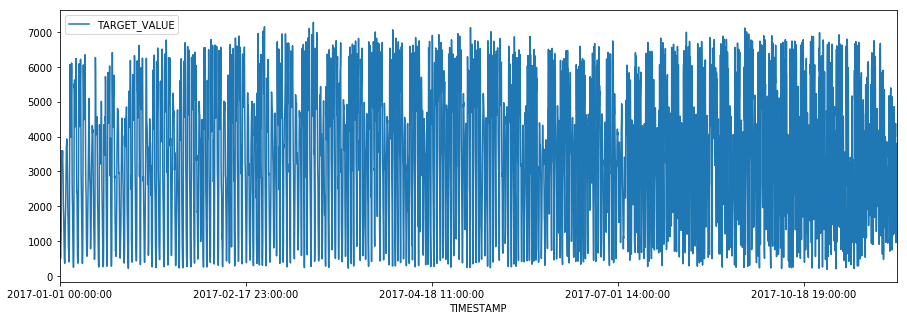

In [109]:
target_df_2017.plot()

What we now see is that there are no periods of missing data in mass, though it does look a bit sparser earlier in the year and more filled in towards the end of the year. We are going to use a smoothing technique to fill in the missing values. This global dataframe will serve as the basis for our target and related dataset.

Assumptions being made:

* Smoothing will not cause a massive problem.
* It is ok to use the previously known value for all nulls.



In [120]:
original_data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
working_df = original_data.copy()

working_df.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
36604,None,291.29,0.0,0.0,90,Drizzle,light intensity drizzle,2017-08-25 22:00:00,2863
33601,None,286.76,0.0,0.0,1,Clear,sky is clear,2017-05-14 04:00:00,382
20741,None,267.57,0.0,0.0,90,Haze,haze,2016-01-21 04:00:00,874
43959,None,287.62,0.0,0.0,1,Clear,sky is clear,2018-05-09 22:00:00,1736
3760,None,253.08,0.0,0.0,1,Clear,sky is clear,2013-02-21 04:00:00,791
30697,None,262.33,0.0,0.0,5,Clear,sky is clear,2017-02-01 21:00:00,2571
17592,None,286.81,0.0,0.0,1,Clear,sky is clear,2015-08-20 23:00:00,1407
42310,None,273.55,0.0,0.0,75,Clouds,broken clouds,2018-03-13 14:00:00,5187
10478,None,248.63,0.0,0.0,1,Clear,sky is clear,2013-12-07 04:00:00,364
44334,None,294.34,0.0,0.0,1,Clear,sky is clear,2018-05-24 04:00:00,883


In [121]:
working_df.columns = ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description','timestamp', 'traffic_volume']

In [122]:
working_df.sample(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,timestamp,traffic_volume
37082,None,289.93,0.00,0.0,1,Mist,mist,2017-09-12 00:00:00,616
37374,None,303.29,0.00,0.0,40,Clouds,scattered clouds,2017-09-22 20:00:00,3471
17414,None,295.44,0.51,0.0,1,Rain,light rain,2015-08-16 06:00:00,858
32576,None,279.77,0.00,0.0,40,Clouds,scattered clouds,2017-04-11 13:00:00,4729
25875,None,290.87,0.28,0.0,75,Rain,light rain,2016-08-20 14:00:00,4399


In [123]:
# Now drop holiday because we do not need it
working_df = working_df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description','timestamp', 'traffic_volume']]
working_df.sample(5)

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,timestamp,traffic_volume
25645,292.58,9.00,0.0,8,Rain,heavy intensity rain,2016-08-11 03:00:00,478
13246,272.11,0.44,0.0,20,Rain,light rain,2014-03-28 10:00:00,4774
24426,297.68,0.00,0.0,75,Clouds,broken clouds,2016-06-24 14:00:00,5078
1575,271.22,0.00,0.0,59,Clouds,broken clouds,2012-11-30 08:00:00,5913
7445,292.46,0.00,0.0,0,Clear,Sky is Clear,2013-07-05 08:00:00,3383


In [124]:
# Build the index first
idx = pd.DatetimeIndex(freq="h", start="2017-01-01", periods=365*24*2)

In [125]:
full_df = pd.DataFrame(index=idx)
full_df.head(3)

""
2017-01-01 00:00:00
2017-01-01 01:00:00
2017-01-01 02:00:00


In [129]:
print (full_df.index.min())
print (full_df.index.max())

2017-01-01 00:00:00
2018-12-31 23:00:00


In [126]:
# Next configure the index for the working_df
working_df.set_index('timestamp', inplace=True)
working_df = working_df.drop_duplicates(keep ='first')
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48175 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
temp                   48175 non-null float64
rain_1h                48175 non-null float64
snow_1h                48175 non-null float64
clouds_all             48175 non-null int64
weather_main           48175 non-null object
weather_description    48175 non-null object
traffic_volume         48175 non-null int64
dtypes: float64(3), int64(2), object(2)
memory usage: 2.9+ MB


In [127]:
restricted_df = working_df.loc['2017-01-01':]

In [128]:
print (restricted_df.index.min())
print (restricted_df.index.max())

2017-01-01 00:00:00
2018-09-30 23:00:00


In [130]:
merged_df = full_df.join(restricted_df, how='outer')

In [131]:
print (merged_df.index.min())
print (merged_df.index.max())

2017-01-01 00:00:00
2018-12-31 23:00:00


In [132]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20817 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
temp                   18537 non-null float64
rain_1h                18537 non-null float64
snow_1h                18537 non-null float64
clouds_all             18537 non-null float64
weather_main           18537 non-null object
weather_description    18537 non-null object
traffic_volume         18537 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.3+ MB


In [133]:
merged_df.drop_duplicates(keep ='first')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20817 entries, 2017-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
temp                   18537 non-null float64
rain_1h                18537 non-null float64
snow_1h                18537 non-null float64
clouds_all             18537 non-null float64
weather_main           18537 non-null object
weather_description    18537 non-null object
traffic_volume         18537 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.3+ MB


In [134]:
merged_df.ffill()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-01-01 00:00:00,269.75,0.0,0.0,75.0,Clouds,broken clouds,1848.0
2017-01-01 01:00:00,269.95,0.0,0.0,1.0,Clear,sky is clear,1806.0
2017-01-01 02:00:00,269.75,0.0,0.0,1.0,Clear,sky is clear,1211.0
2017-01-01 03:00:00,269.65,0.0,0.0,40.0,Clouds,scattered clouds,794.0
2017-01-01 04:00:00,269.48,0.0,0.0,1.0,Clear,sky is clear,500.0
2017-01-01 05:00:00,269.22,0.0,0.0,1.0,Clear,sky is clear,513.0
2017-01-01 06:00:00,268.90,0.0,0.0,1.0,Clear,sky is clear,821.0
2017-01-01 07:00:00,268.34,0.0,0.0,40.0,Clouds,scattered clouds,950.0
2017-01-01 08:00:00,267.90,0.0,0.0,1.0,Clear,sky is clear,1284.0
2017-01-01 09:00:00,267.71,0.0,0.0,20.0,Clouds,few clouds,2279.0


At this point we now have a working master time series dataset for 2 years ( though let us be very clear that 2018 is going to look weird with projecting values from September onward). We can only predict 20 days of hourly data anyway with Forecast so we are going to learn from all of 2017 then predict into 2017.

In [135]:
# Build target dataframe for time series data now.

target_time_series_df = merged_df.copy()
target_time_series_df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-01-01 00:00:00,269.75,0.0,0.0,75.0,Clouds,broken clouds,1848.0
2017-01-01 01:00:00,269.95,0.0,0.0,1.0,Clear,sky is clear,1806.0
2017-01-01 02:00:00,269.75,0.0,0.0,1.0,Clear,sky is clear,1211.0
2017-01-01 03:00:00,269.65,0.0,0.0,40.0,Clouds,scattered clouds,794.0
2017-01-01 04:00:00,269.48,0.0,0.0,1.0,Clear,sky is clear,500.0


In [138]:
target_time_series_df = target_time_series_df[['traffic_volume']]
target_time_series_df.head()

,traffic_volume
2017-01-01 00:00:00,1848.0
2017-01-01 01:00:00,1806.0
2017-01-01 02:00:00,1211.0
2017-01-01 03:00:00,794.0
2017-01-01 04:00:00,500.0


In [140]:
target_time_series_df = target_time_series_df.loc['2017-01-01': '2017-12-31']
print (target_time_series_df.index.min())
print (target_time_series_df.index.max())

2017-01-01 00:00:00
2017-12-31 23:00:00


In [141]:
target_time_series_df['ITEM_ID'] = "1"

In [142]:
target_time_series_df.head()

,traffic_volume,ITEM_ID
2017-01-01 00:00:00,1848.0,1
2017-01-01 01:00:00,1806.0,1
2017-01-01 02:00:00,1211.0,1
2017-01-01 03:00:00,794.0,1
2017-01-01 04:00:00,500.0,1


In [144]:
target_time_series_df.to_csv("data/target_time_series.csv", header=False)

In [145]:
target_time_series_filename = "target_time_series.csv"
target_time_series_path = "data/target_time_series.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file(target_time_series_path)

In [146]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_poc_clean'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename

In [147]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [148]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)



{'DatasetGroupName': 'forecast_poc_clean_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:059124553121:dataset-group/forecast_poc_clean_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 28, 15, 29, 22, 103000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 28, 15, 29, 22, 103000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '9ca5fb42-a6fd-48a8-952a-025a07f3e5c8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 28 Dec 2019 15:29:26 GMT',
   'x-amzn-requestid': '9ca5fb42-a6fd-48a8-952a-025a07f3e5c8',
   'content-length': '267',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [149]:
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [150]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [151]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_poc_clean_ds',
 'DatasetName': 'forecast_poc_clean_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 28, 15, 29, 43, 44000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 28, 15, 29, 43, 44000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '72f9f9f6-a686-433d-b706-3d34018975fb',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 28 Dec 2019 15:29:46 GMT',
   'x-amzn-requestid': '72f9f9f6-a686-433d-b706-3d34018975fb',
   'content-length': '503',
   'connection': 'keep-alive'},
  'RetryAtt

In [152]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])



{'ResponseMetadata': {'RequestId': '236aad9f-0ad5-4580-a07d-999010fa9d61',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 28 Dec 2019 15:29:52 GMT',
   'x-amzn-requestid': '236aad9f-0ad5-4580-a07d-999010fa9d61',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [153]:
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [154]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_poc_clean_ds/DSIMPORT_JOB_TARGET


In [155]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


## To save time I am pivoting to creating the forecasts within the console. The following work will be getting a related datas set imported.

In [157]:
# Build target dataframe for time series data now.

related_time_series_df = merged_df.copy()
related_time_series_df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-01-01 00:00:00,269.75,0.0,0.0,75.0,Clouds,broken clouds,1848.0
2017-01-01 01:00:00,269.95,0.0,0.0,1.0,Clear,sky is clear,1806.0
2017-01-01 02:00:00,269.75,0.0,0.0,1.0,Clear,sky is clear,1211.0
2017-01-01 03:00:00,269.65,0.0,0.0,40.0,Clouds,scattered clouds,794.0
2017-01-01 04:00:00,269.48,0.0,0.0,1.0,Clear,sky is clear,500.0


In [160]:
related_time_series_df = related_time_series_df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']]
related_time_series_df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
2017-01-01 00:00:00,269.75,0.0,0.0,75.0,Clouds,broken clouds
2017-01-01 01:00:00,269.95,0.0,0.0,1.0,Clear,sky is clear
2017-01-01 02:00:00,269.75,0.0,0.0,1.0,Clear,sky is clear
2017-01-01 03:00:00,269.65,0.0,0.0,40.0,Clouds,scattered clouds
2017-01-01 04:00:00,269.48,0.0,0.0,1.0,Clear,sky is clear


In [161]:
related_time_series_df = related_time_series_df[['temp', 'rain_1h', 'snow_1h', 'clouds_all','weather_description']]
related_time_series_df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_description
2017-01-01 00:00:00,269.75,0.0,0.0,75.0,broken clouds
2017-01-01 01:00:00,269.95,0.0,0.0,1.0,sky is clear
2017-01-01 02:00:00,269.75,0.0,0.0,1.0,sky is clear
2017-01-01 03:00:00,269.65,0.0,0.0,40.0,scattered clouds
2017-01-01 04:00:00,269.48,0.0,0.0,1.0,sky is clear


In [162]:
related_time_series_df['ITEM_ID'] = "1"

In [175]:
related_time_series_df = related_time_series_df.ffill()

In [176]:
related_time_series_df.isnull()

,temp,rain_1h,snow_1h,clouds_all,weather_description,ITEM_ID
2017-01-01 00:00:00,False,False,False,False,False,False
2017-01-01 01:00:00,False,False,False,False,False,False
2017-01-01 02:00:00,False,False,False,False,False,False
2017-01-01 03:00:00,False,False,False,False,False,False
2017-01-01 04:00:00,False,False,False,False,False,False
2017-01-01 05:00:00,False,False,False,False,False,False
2017-01-01 06:00:00,False,False,False,False,False,False
2017-01-01 07:00:00,False,False,False,False,False,False
2017-01-01 08:00:00,False,False,False,False,False,False
2017-01-01 09:00:00,False,False,False,False,False,False


In [177]:
related_time_series_df.to_csv("data/related_time_series.csv", header=False)

In [164]:
related_schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"temperature",
         "AttributeType":"float"
      },
       {
         "AttributeName":"rain_1h",
         "AttributeType":"float"
      },
       {
         "AttributeName":"snow_1h",
         "AttributeType":"float"
      },
       {
         "AttributeName":"clouds_all",
         "AttributeType":"float"
      },
       {
         "AttributeName":"weather",
         "AttributeType":"string"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [165]:
related_DSN = datasetName + "_related"
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='RELATED_TIME_SERIES',
                    DatasetName=related_DSN,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = related_schema
)

In [166]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_poc_clean_ds_related',
 'DatasetName': 'forecast_poc_clean_ds_related',
 'Domain': 'CUSTOM',
 'DatasetType': 'RELATED_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'temperature', 'AttributeType': 'float'},
   {'AttributeName': 'rain_1h', 'AttributeType': 'float'},
   {'AttributeName': 'snow_1h', 'AttributeType': 'float'},
   {'AttributeName': 'clouds_all', 'AttributeType': 'float'},
   {'AttributeName': 'weather', 'AttributeType': 'string'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 28, 15, 44, 27, 642000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 28, 15, 44, 27, 642000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'e9d8c8a6-95ab-42f5-b417-48147bbf912e',
  'HTTPSt

In [178]:
related_time_series_filename = "related_time_series.csv"
related_time_series_path = "data/related_time_series.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(related_time_series_filename).upload_file(related_time_series_path)

In [168]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn, "arn:aws:forecast:us-east-1:059124553121:dataset/forecast_poc_clean_ds"])

{'ResponseMetadata': {'RequestId': '1f578384-a0a7-4542-a273-9a7a6701f0f3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 28 Dec 2019 15:46:16 GMT',
   'x-amzn-requestid': '1f578384-a0a7-4542-a273-9a7a6701f0f3',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [169]:
s3DataPath = "s3://"+bucket_name+"/"+related_time_series_filename

In [179]:
datasetImportJobName = 'DSIMPORT_JOB_RELATED2'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [180]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_poc_clean_ds_related/DSIMPORT_JOB_RELATED2


In [181]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE
